In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [2]:
# read the pickle files to get fitted models
# get appropriate test data to fcast
# fcast
# evaluate against true values + calc quantile score
# plot

In [3]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)
custom_date = '2024-01-10'
t_now = pd.Timestamp(custom_date).replace(hour=0, minute=0, second=0, microsecond=0)

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)).tz_localize('CET'))
print(subm_timestamps)

wed = 2024-01-10 00:00:00
thu = 2024-01-11 00:00:00
[Timestamp('2024-01-12 12:00:00+0100', tz='CET'), Timestamp('2024-01-12 16:00:00+0100', tz='CET'), Timestamp('2024-01-12 20:00:00+0100', tz='CET'), Timestamp('2024-01-13 12:00:00+0100', tz='CET'), Timestamp('2024-01-13 16:00:00+0100', tz='CET'), Timestamp('2024-01-13 20:00:00+0100', tz='CET')]


In [4]:
# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2018-01-01'
end     = df_energy['timestamp_CET'].max()
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]

print('- '*15)
print(f"take smaller dataset ... from {start} to {end}")
print(df_energy_small.info())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# feature engineering and preparing training data

df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_fturs = df_energy_fturs['gesamt']

X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_dummy = df_energy_dummy['gesamt']

C:\2023_11-PTSFC
to_date is later than 2023-11-01, using recent data as well !
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79123 entries, 2014-12-31 23:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79123 non-null  datetime64[ns, CET]
 1   gesamt         79123 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
- - - - - - - - - - - - - - - 
take smaller dataset ... from 2018-01-01 to 2024-01-10 18:00:00+01:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52818 entries, 2018-01-01 00:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  52818 non-null  datetime64[ns, CET]
 1   gesamt         52818 n

In [5]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
#     pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
#     pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# read trained models

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
train_start = X_train_dummy.index.min().strftime('%Y%m%d')
train_end = X_train_dummy.index.max().strftime('%Y%m%d')

with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'rb') as handle:
    all_models_quant_reg = pickle.load(handle)

with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'rb') as handle:
    all_models_grad_boost = pickle.load(handle)


2024-01-03 17:00:00+00:00 2024-01-10 17:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-10 18:00:00+00:00 to 2024-01-11 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


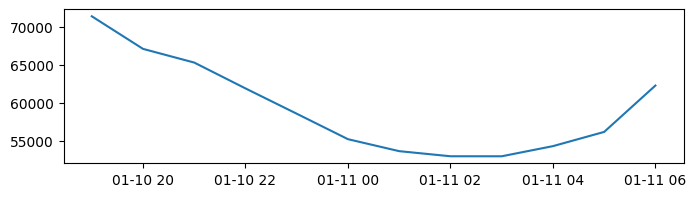

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-11 06:00:00+00:00 to 2024-01-11 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


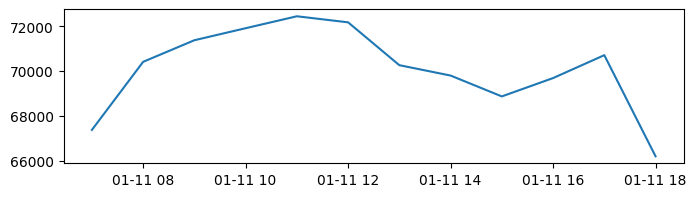

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-11 18:00:00+00:00 to 2024-01-12 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


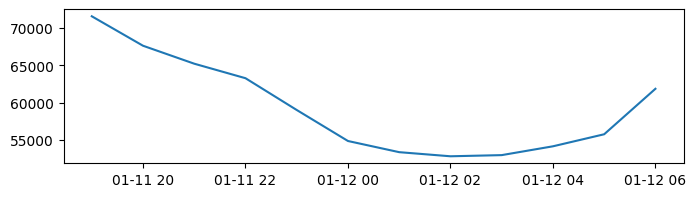

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-12 06:00:00+00:00 to 2024-01-12 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


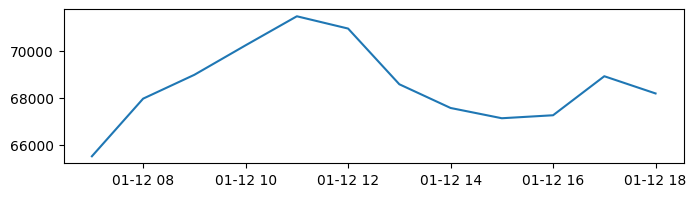

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-12 18:00:00+00:00 to 2024-01-13 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


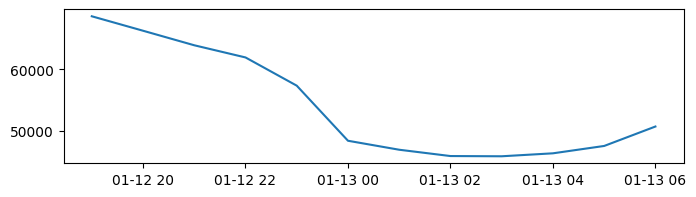

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-13 06:00:00+00:00 to 2024-01-13 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


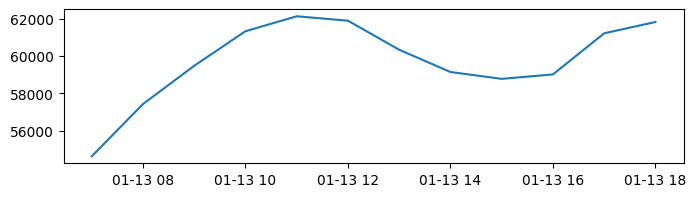

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-13 18:00:00+00:00 to 2024-01-14 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


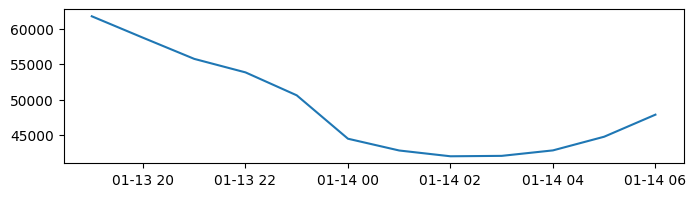

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-14 06:00:00+00:00 to 2024-01-14 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


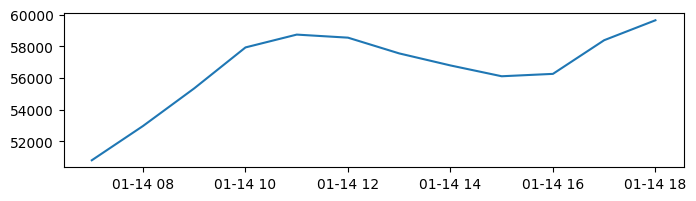

= = = = = = = = = = = = = = = 
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 18:00:00+00:00,62341.901493,69104.578668,71391.542389,71881.749487,73538.382842
2024-01-10 19:00:00+00:00,60170.997044,64881.238780,67108.984224,68434.082153,71597.979052
2024-01-10 20:00:00+00:00,57034.138927,62125.576903,65310.514719,66190.999570,68620.291471
2024-01-10 21:00:00+00:00,53560.238396,59845.389135,61916.190124,63139.119191,66151.442551
2024-01-10 22:00:00+00:00,51362.194613,56450.532481,58593.162884,59623.567797,63391.187342
...,...,...,...,...,...
2024-01-14 13:00:00+00:00,49628.573697,53657.209633,56796.781277,58967.535408,62459.624310
2024-01-14 14:00:00+00:00,48870.645299,52779.264467,56114.434176,58612.378711,61333.993208
2024-01-14 15:00:00+00:00,49387.890747,53670.950197,56265.083310,58724.998097,62254.892923
2024-01-14 16:00:00+00:00,51484.820189,56173.665259,58389.589875,61580.943410,65169.747005


In [6]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(start, end)

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()

for fcast_iter in range(8):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print('- '*15) 
    print(f"> to be forecasted")
    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    print('- '*15)    
    print(f'> start prediction ...')

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    plt.figure(figsize=(8,2))
    plt.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)
    plt.show()

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print('= '*15)
print('= '*15)
print(f"all iterative fcasts done ...")
display(df_fcast_iter_all)